# 1: Import Packages and Define Functions

In [316]:
# Import some libraries that will be used
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector
import sys
sys.path.insert(1, '/Users/brianmccabe/DataScience/Flatiron/mod5/Emoji_Analysis/Scripts/')
import config
import warnings
warnings.filterwarnings('ignore')



pd.set_option('display.max_columns', 300)

%matplotlib inline

In [317]:
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn import metrics
from sklearn.model_selection import train_test_split
from matplotlib import cm
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.naive_bayes import MultinomialNB
import string
import scipy
import emoji
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import re
from textblob import TextBlob
from wordcloud import WordCloud


nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/brianmccabe/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/brianmccabe/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/brianmccabe/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [318]:
def extract_emojis(s):
    return ''.join(c for c in s if c in emoji.UNICODE_EMOJI)

In [319]:
# we can define a function that removes stopwords 
def process_tweet(tweet):
    tweet = str(tweet).lower()
    tokens = nltk.word_tokenize(tweet)
    stopwords_removed = [token.lower() for token in tokens if token.lower() not in stopwords]
    return stopwords_removed

In [320]:
#set stopwords and punctuations
stopwords = stopwords.words('english')
stopwords += list(string.punctuation)
stopwords += ["n't", "' '", "'re'","”","``","“","''","’","'s","'re","http","https", 'rt']
alph = ['a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z']
stopwords += alph

In [321]:
def check_for_flags(s):
    s = str(s)
    has_flag = False
    for flag in flags:
        if flag in s:
            has_flag = True
    return has_flag

In [322]:
from nltk.stem import WordNetLemmatizer, PorterStemmer
  
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

In [323]:
def unique_emoji_count(s):
    return len(set([c for c in s]))

In [324]:
def condence_emojis(s):
    try:
        return set(s).pop()
    except:
        return None

In [325]:
def check_profanity(tweet):
    profane = pd.read_csv("profane_words.csv", header=None)

    profane = list(profane.loc[:,0])
    count = 0
    tweet = tweet.lower()
    tokens = nltk.word_tokenize(tweet)
    for word in tokens:
        if word in profane:
            count += 1
    return count/len(tweet)

In [326]:
def remove_http(tweet):
    pattern = '((http|https)\w+\s\w+\s\w+\s\w+)'
    try:
        return tweet.replace(re.findall(pattern, tweet)[0][0], "")
    except:
        return tweet

In [327]:
def remove_username(tweet):
    try:
        p = '[\w\s]+(@\w+)'
        return tweet.replace(re.findall(p, tweet)[0], "")
    except:
        return tweet

In [328]:
def get_subjectivity(tweet):
    b = TextBlob(tweet)
    return b.sentiment.subjectivity

In [329]:
def exclamation_percentage(tweet):
    count = np.char.count(tweet, sub ='!').sum()
    return count / len(tweet)

In [330]:
analyzer = SentimentIntensityAnalyzer()
def sentiment_scores(s):
    return analyzer.polarity_scores(s)['compound']

In [415]:
def capital_percentage(tweet):
    tokens = nltk.word_tokenize(tweet)
    cap_count = 0
    for item in tokens:
        if item.isupper():
            cap_count += 1
    return cap_count/len(tokens)

In [331]:
def remove_emojis(s):
    pattern = "[@!\w]+"
    return ' '.join(re.findall(pattern, s))

In [332]:
def ReplaceThreeOrMore(tweet):
    # pattern to look for three or more repetitions of any character, including
    # newlines.
    pattern = re.compile(r"(.)\1{2,}", re.DOTALL) 
    return pattern.sub(r"\1\1", tweet)

In [333]:
def clean_txt(tweet):
    tweet = remove_http(tweet)
    tweet = remove_username(tweet)
    tweet = ReplaceThreeOrMore(tweet)
    tokens = process_tweet(tweet)
    return ' '.join([lemmatizer.lemmatize(w) for w in tokens])

# 2: Load in the Data and Clean

In [334]:
connection = mysql.connector.connect(host=config.host,
                                         user=config.user,
                                         port=config.port,
                                         password=config.password,
                                         database=config.database,
                                         auth_plugin='mysql_native_password')

cursor = connection.cursor()
query = "SELECT tweet FROM Election_Tweets WHERE HEX(tweet) RLIKE '^(..)*F.'"

df = pd.read_sql(query, connection)

In [335]:
df.head()

,tweet
0,!! But I wanna stay up and see how this electi...
1,!! TODAY'S VOTE !!\n\n🗳 https://t.co/AKM1Fbo8X...
2,!👍🏼🤨..RIGHT-on! Anyone who thinks tRump WON’T ...
3,""" i dont want to vote for pedophile biden"" 😫😫 ..."
4,"""""Get yourself a Lover who looks at \nyou, t..."


In [336]:
df['emoji'] = df.tweet.apply(extract_emojis)

In [337]:
# We can see that emoji flags have strange representations. I will remove them from the dataset.
## NOTE BELOW LIKELY WILL NO LONGER SHOW A FLAG, SINCE I'VE BEEN PULLING DATA EVERY DAY
## But, flags were basically as follows....alone as a string, they are equal to a flag plus a white space
## HOWEVER, once you strip it apart into a list form, it becomes a list of two emoticon-characters
## For example, Brazil Flag as a string is "Flag ", but as a list, it is ["[B], [R]"]
## Below, i actually acquire these codes from wikipedia to aid in removing flags from the dataset
[c for c in df.emoji.loc[9]]

['🤣', '🤣', '🤣']

In [338]:
import flag
from bs4 import BeautifulSoup
import requests

In [339]:
url = 'https://en.wikipedia.org/wiki/Regional_indicator_symbol'
page = requests.get(url)
soup = BeautifulSoup(page.content, 'html.parser')

In [340]:
flags = []
skip_first = 0
for item in soup.find('tbody').find_all('tr'):
    if skip_first == 0:
        skip_first += 1
        continue
    flagcode = item.find_all('td')[1].text
    flags.append(flag.flag(flagcode))

flags[0:5]    

['🇦🇨', '🇦🇩', '🇦🇪', '🇦🇫', '🇦🇬']

In [341]:
df.emoji.apply(check_for_flags).value_counts()

False    38192
True      5929
Name: emoji, dtype: int64

In [342]:
df['has_flag'] = df.emoji.apply(check_for_flags)
df = df[df.has_flag == False]
df.drop('has_flag', axis=1, inplace=True)

In [343]:
df['unique_emoji_count'] = df.emoji.apply(unique_emoji_count)

In [344]:
df['sentiment_score'] = df.tweet.apply(sentiment_scores)

In [345]:
df.to_csv("tweets_w_all_emojis_present_NEW.csv")

In [346]:
df.head()

,tweet,emoji,unique_emoji_count,sentiment_score
0,!! But I wanna stay up and see how this electi...,🥴,1,0.5696
1,!! TODAY'S VOTE !!\n\n🗳 https://t.co/AKM1Fbo8X...,🗳👉🏻,3,0.0000
2,!👍🏼🤨..RIGHT-on! Anyone who thinks tRump WON’T ...,👍🏼🤨,3,0.0000
3,""" i dont want to vote for pedophile biden"" 😫😫 ...",😫😫,1,-0.7447
4,"""""Get yourself a Lover who looks at \nyou, t...",💌,1,0.8516


In [347]:
pattern = "[@\w]+"
' '.join(re.findall(pattern, df.tweet.iloc[2]))

'RIGHT on Anyone who thinks tRump WON T declare an early victory isn t paying attention tRump and GOP has an https t co oHDCF8GjeW'

In [348]:
df['exclamation_points'] = df.tweet.progress_apply(exclamation_percentage)

100%|██████████| 38192/38192 [00:00<00:00, 89419.20it/s]


In [349]:
df['tweet'] = df.tweet.apply(remove_emojis)

In [350]:
df.head()

,tweet,emoji,unique_emoji_count,sentiment_score,exclamation_points
0,!! But I wanna stay up and see how this electi...,🥴,1,0.5696,0.024096
1,!! TODAY S VOTE !! https t co AKM1Fbo8X8 MAMAV...,🗳👉🏻,3,0.0000,0.033898
2,! RIGHT on! Anyone who thinks tRump WON T decl...,👍🏼🤨,3,0.0000,0.014286
3,i dont want to vote for pedophile biden im sor...,😫😫,1,-0.7447,0.000000
4,Get yourself a Lover who looks at you the way ...,💌,1,0.8516,0.007353


In [351]:
df.emoji.isna().sum()

0

In [352]:
df.dropna(inplace=True)

In [353]:
df.isna().sum()

tweet                 0
emoji                 0
unique_emoji_count    0
sentiment_score       0
exclamation_points    0
dtype: int64

In [354]:
df = df[df.unique_emoji_count > 0]

In [355]:
df.reset_index(inplace=True)

In [356]:
df[(df.emoji.apply(len) == 1)].emoji.value_counts()[:30]

😂    1699
😭    1017
🗳     879
🤔     578
💙     539
🤣     537
🙄     468
🚨     468
🔴     446
🥴     359
🙏     340
🥺     339
👇     326
🏆     313
💜     303
💀     289
👀     264
👍     250
😊     223
😁     223
🔥     217
🥰     213
😔     212
😳     206
😬     188
😌     186
😉     185
😅     173
🙃     171
💯     165
Name: emoji, dtype: int64

In [357]:
# Creating a dataframe of singular emojis to the average sentiment score they obtain
df2 = df.copy()
df2 = df2[df2.unique_emoji_count == 1]
df2['emoji'] = df2.emoji.apply(condence_emojis)
emoji_sentiment_mappings = df2[['emoji', 'sentiment_score']].groupby('emoji').mean()

In [358]:
def impute_top_emoji(s, mappings = emoji_sentiment_mappings, data = df):
    val = df[df.emoji == s].sentiment_score.values[0]
    s = list(set(s))
    closest = 100
    top = s[0]
    for i in range(0, len(s)):
        try:
            if abs(val - emoji_sentiment_mappings.loc[s[i]].sentiment_score) < closest:
                closest = abs(val - emoji_sentiment_mappings.loc[s[i]].sentiment_score)
                top = s[i]
        except:
            continue
    return top

In [359]:
from tqdm import tqdm
tqdm.pandas()

In [360]:
df['top_emoji'] = df.emoji.progress_apply(impute_top_emoji)

100%|██████████| 38092/38092 [01:41<00:00, 376.29it/s]


In [361]:
df.drop(["unique_emoji_count", "emoji"], axis=1, inplace=True)
df.drop('index', axis=1, inplace=True)

In [362]:
emoji_counts = dict(df.top_emoji.value_counts())

In [363]:
df['emoji_frequency'] = df.top_emoji.map(emoji_counts)

In [364]:
df.head()

,tweet,sentiment_score,exclamation_points,top_emoji,emoji_frequency
0,!! But I wanna stay up and see how this electi...,0.5696,0.024096,🥴,439
1,!! TODAY S VOTE !! https t co AKM1Fbo8X8 MAMAV...,0.0000,0.033898,👉,198
2,! RIGHT on! Anyone who thinks tRump WON T decl...,0.0000,0.014286,🤨,108
3,i dont want to vote for pedophile biden im sor...,-0.7447,0.000000,😫,103
4,Get yourself a Lover who looks at you the way ...,0.8516,0.007353,💌,18


In [365]:
df.to_csv("tweets_NEW.csv")

# 3. Explore the Data and Create Initial Insights

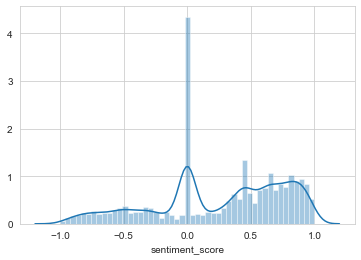

In [366]:
sns.distplot(df.sentiment_score)

The sentiment score above shows a wide range of sentiments for all the emojis. Hard to get any important insight from something this broad.

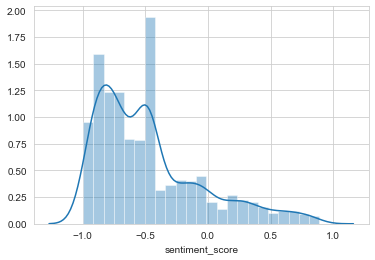

In [367]:
sns.distplot(df[df.top_emoji == '😭'].sentiment_score)

Inspecting the sentiment distribution of one of our top emojis shows that, to some degree, and emoji represents a certain sentiment, with some outliers that could be do to things like sarcasm or different emotions entirely.

This crying emoji will be used to represent a feeling of sadness, however, people often times use it in a positive light (crying laughing). 

Because this emoji is used so frequently by so many people, and used in so many different ways, I won't include it in my emoji class for sadness. Crying laughing can represent too many emotions, and thus doesn't make sense to train on a specifically sad emotion.

Additionally, this doesn't cause the sad class to be the lowest amount of data, 'fearful' is still by far the least frequent.

### Important Note

See "selection biased" EDA notebook. Originally, I tried segmenting into more target classes based on data that was collected in a way that lent itself to selection bias.

Upon research into the subject matter, I found that studies have been done by various teams at various companies, with a notable one by instagram and another by Paul Ekman. Their research shows that, of all the emotions that emojis can represent, through NLP processing, the best way in which to segment different emotions is into 4 classes, discussed below.

Paul Ekman’s original theory about universal emotion categories suggests that human emotions can be categorized as one out of six different classes; anger, disgust,fearful, happy, sad and surprise. 

Furthermore, Instagram’s engineering team recently published a study based on 50 million English Instagram comments andcaptions from 2015 with a visualization of how emojis appear in similar contexts.

The resulting 2D semantic map indicates which emojis that can be considered as contextually similar. It can be concluded from the semantic map that emojis which could be considered a representations of the emotions ANGER, FEARFUL, HAPPY and SAD are clearly separated.

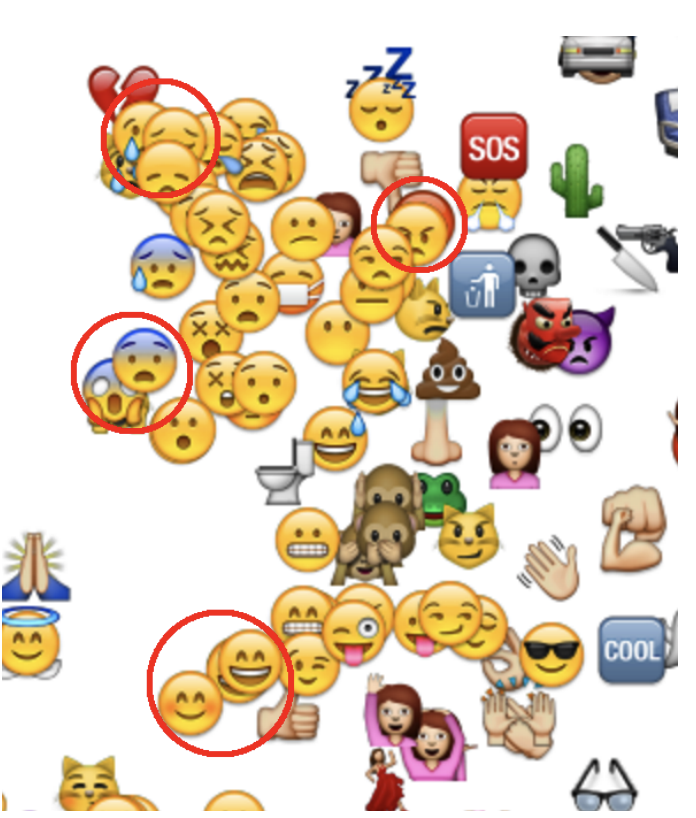

In [370]:
from IPython.display import Image
Image(filename='instagram_semantic_map.png', width=300)

One has to be careful not to read *too* much into this clustering representation since it is an attempt to produce a 2D space out of a 100D one. But it’s clear that semantics are being approximated in our representation. 

In [378]:
## Because of a lack of data, I am taking the liberty of grouping some extras into each category, but it still aligns
## with the mapping from instagram

sad = ['😩','😢','😫','😓','😟','🙁','😞']       ## removed '😔', since it had a postive sentiment
                                                        ##'😭' was excluded due to a wide range in emotion usage
                                                        ## removed '😥', since it had a outlier sentiment compared to rest
fearful = [ '😱', '😰','😨']  ## 'removed 😳', since it had a outlier sentiment compared to rest
angry = ['😡','😠','🤬']  # 'removed '😤', since it had a outlier sentiment compared to rest
happy = ['😊','🤗','😁','😌','😀','🙂','😄']

In [379]:
print("Sentiments for sad")
for i in range(0,len(sad)):
    print(df[df.top_emoji==sad[i]].sentiment_score.mean())
print("----------------------")
print("Sentiments for fearful")
for i in range(0,len(fearful)):
    print(df[df.top_emoji==fearful[i]].sentiment_score.mean())
print("----------------------")
print("Sentiments for angry")
for i in range(0,len(angry)):
    print(df[df.top_emoji==angry[i]].sentiment_score.mean())
print("----------------------")
print("Sentiments for happy")
for i in range(0,len(happy)):
    print(df[df.top_emoji==happy[i]].sentiment_score.mean())


Sentiments for sad
-0.295413360323887
-0.3052152380952382
-0.4401223300970871
-0.3381977777777777
-0.2967032258064516
-0.4611772727272727
-0.48721111111111143
----------------------
Sentiments for fearful
-0.7102236220472438
-0.22501515151515147
-0.5146499999999999
----------------------
Sentiments for angry
-0.15643027027027023
-0.6545285714285715
-0.20333333333333337
----------------------
Sentiments for happy
0.8116461333333331
0.5877258928571429
0.5650864705882347
0.4989264822134383
0.4507660493827158
0.4931970802919708
0.7321231481481483


In [380]:
all_e = sad + fearful + angry + happy

In [381]:
new_df = df[df.top_emoji.isin(all_e)]

In [382]:
conditions = [
    new_df.top_emoji.isin(sad[1:]),
    new_df.top_emoji.isin(fearful[1:]),
    new_df.top_emoji.isin(angry[1:]),
    new_df.top_emoji.isin(happy[1:])
    
]

choices = [
    sad[0],
    fearful[0],
    angry[0], 
    happy[0]
]

new_df.top_emoji = np.select(conditions, choices, default = new_df.top_emoji)

In [383]:
new_df.top_emoji.value_counts()

😊    1487
😩     625
😡     335
😱     170
Name: top_emoji, dtype: int64

In [384]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

def getImage(path):
    return OffsetImage(plt.imread(path))

In [385]:
new_df.drop('emoji_frequency', axis=1, inplace=True)
freq_map = dict(new_df.top_emoji.value_counts())
new_df['emoji_frequency'] = new_df.top_emoji.map(freq_map)

new_df.to_csv("tweets_4_classes.csv")


In [386]:
emojis = new_df.groupby('top_emoji').mean()
emojis.to_csv("emojis_NEW.csv")


In [387]:
emojis

,sentiment_score,exclamation_points,emoji_frequency
top_emoji,,,
😊,0.610768,0.003879,1487
😡,-0.233999,0.005353,335
😩,-0.351983,0.001567,625
😱,-0.604532,0.004122,170


In [388]:
pics = ['happy.png','angry.png','cry.png', 'scary.png']

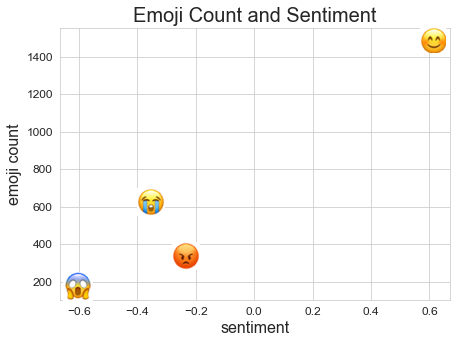

In [389]:
fig, ax = plt.subplots(figsize = (7,5))

sns.scatterplot(x=emojis.sentiment_score, y=emojis.emoji_frequency, ax=ax)
sns.set_style("whitegrid")
plt.xticks(fontsize=12)
plt.xlabel('sentiment', fontsize=16)
plt.yticks(fontsize=12)
plt.ylabel('emoji count', fontsize=16)
plt.title("Emoji Count and Sentiment", fontsize = 20)

for x0, y0, pic in zip(emojis.sentiment_score, emojis.emoji_frequency,pics):
    ab = AnnotationBbox(getImage(pic), (x0, y0), frameon=False)
    ax.add_artist(ab)
plt.savefig('../pics/emoji_count_and_sentiment.png')
plt.show()

From the above, it appears that each emoji occupies, on average, its own niche spot for a sentiment score. That being said, the 3 negative emotions are fairly close, and their distributions probably have a lot of overlap. TF IDF will be crucial in differentiating these 3 negative emotions.

It is also interesting to note the emoji counts for each. Data gathering for this project began a few days before the election (11/4) and continued for a few days after election day. It would be cool, in the future, to analyze the emoji usage count for the political tweet searches at a time months after the election.

In [390]:
new_df['profanity'] = new_df.tweet.progress_apply(check_profanity)
new_df['subjectivity'] = new_df.tweet.progress_apply(get_subjectivity)

100%|██████████| 2617/2617 [00:00<00:00, 5541.69it/s]


In [391]:
new_df.head()

,tweet,sentiment_score,exclamation_points,top_emoji,emoji_frequency,profanity,subjectivity
3,i dont want to vote for pedophile biden im sor...,-0.7447,0.000000,😩,625,0.000000,1.00
15,I ll kidnap 1000 children before I let this co...,-0.2942,0.010101,😊,1487,0.010753,0.00
23,omg there s more on the ballot then just the p...,-0.7003,0.000000,😱,170,0.000000,0.50
55,AméricaniseUnTitre The Trump Tower Infernale,0.4588,0.000000,😊,1487,0.000000,0.00
59,Biden will WIN Trump and DeJoy have cheated!! ...,0.5437,0.021429,😊,1487,0.007576,0.35


In [392]:
emoji_counts = dict(new_df.top_emoji.value_counts())

In [393]:
new_df['emoji_frequency'] = new_df.top_emoji.map(emoji_counts)

### Create some Wordclouds

In [394]:
def make_word_cloud(new_df, emoji, file_description):
    df_freq = new_df[new_df['top_emoji']==emoji]
    data = df_freq['tweet']
    processed = list(map(clean_txt, data))
    
    flat = [item.split() for item in processed]
    flat_2 = []
    for row in flat:
        for word in row:
            flat_2.append(word)
    freq = FreqDist(flat_2)
    bar_counts = [x[1] for x in freq.most_common(40)]
    bar_words = [x[0] for x in freq.most_common(40)]
    
    dictionary = dict(zip(bar_words, bar_counts))
    
    # SET THE TWITTER SEARCH KEYWORDS TO ZERO, WANT TO SEE WORDS ASIDE FROM THOSE (THEY ARE MOST FREQURNT FOR OBV REASONS)
    dictionary['vote'] = 0
    dictionary['trump'] = 0
    dictionary['biden'] = 0
    dictionary['election'] = 0
    dictionary['president'] = 0
    
    # Create the word cloud:
    wordcloud = WordCloud(colormap='Spectral').generate_from_frequencies(dictionary)
    # Display the generated image w/ matplotlib:
    plt.figure(figsize=(6,6), facecolor='k')
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.tight_layout(pad=0)
    # Uncomment the next line if you want to save your image:
    plt.savefig('../pics/{}_wordcloud.png'.format(file_description))
    plt.show()


#### HAPPY

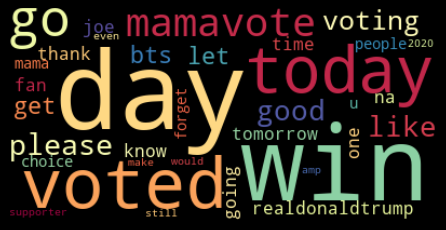

In [395]:
make_word_cloud(new_df, '😊', 'happy')

#### SAD

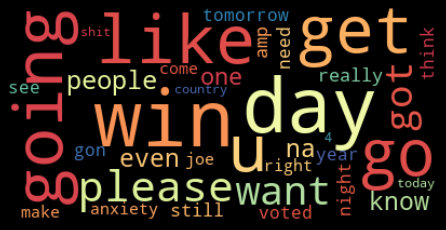

In [396]:
make_word_cloud(new_df, '😩', 'sad')

#### ANGRY

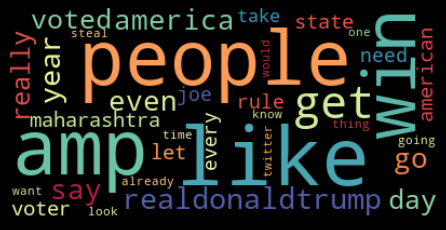

In [397]:
make_word_cloud(new_df, '😡', 'angry')

#### FEARFUL

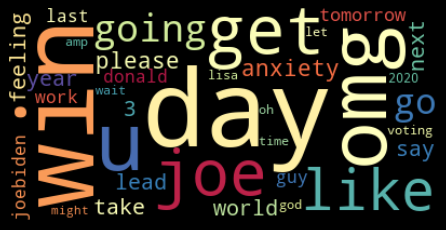

In [398]:
make_word_cloud(new_df, '😱', 'fearful')

## Dive into my custom features

### Explore Sentiment

In [405]:
new_df.groupby('top_emoji').mean().sentiment_score

top_emoji
😊    0.610768
😡   -0.233999
😩   -0.351983
😱   -0.604532
Name: sentiment_score, dtype: float64

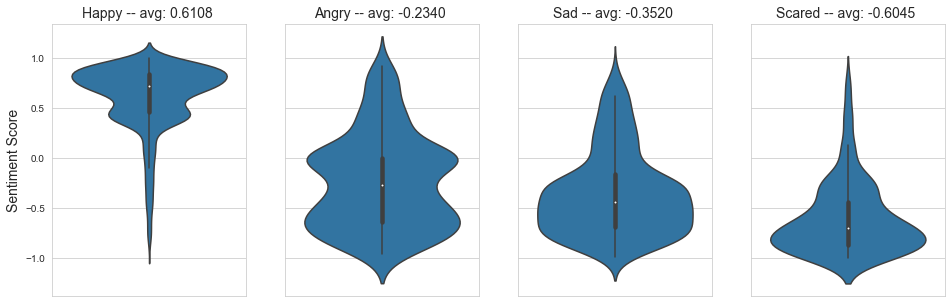

In [437]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(16,5), sharey=True, )
titles = ['Happy', 'Angry', 'Sad', 'Scared']


for i, emoji in enumerate(new_df.groupby('top_emoji').mean().sentiment_score.index):
    sns.violinplot(y=new_df[new_df.top_emoji==emoji].sentiment_score, ax=axes[i])
    val = new_df[new_df.top_emoji == emoji].sentiment_score.mean()
    axes[i].set_title(f"{titles[i]} -- avg: {val:.4f} ", fontsize=14)
    if i == 0:
        axes[i].set_ylabel("Sentiment Score", fontsize=14)
    else:
        axes[i].set_ylabel("")
plt.show()

These violin plots show some interesting differences for sentiment among the target classes.
- Happy is relatively consistent in being positive, with the greatest amount condensed in the ~.55 - .9 range, as indicated by the thickest part.
- Angry is a little different, with values strethcing a much wider spectrum on the sentiment scale. This likely means the 'angry' emotions chosen are not entirely indicative of the same overall sentiment.
- Additionally, because sentiment is a spectrum of -1 to 1 through the use of VADER, it can be seen above that sentiment alone doesn't really pick up on emotions. Sadness, anger, and fear are all considered negative emotions, hence the negative score, but for all intent and purposes angry, sad, and fear could all be anyone on the negative spectrum.
- That being said, Fear looks to be the most consistent with a low sentiment score, indicated by the think upper portion and the clumped, thick lower portion.
- All in all, this feature will hopefully aid in classification, along with NLP techniques.

### Explore Profanity

In [407]:
new_df.groupby('top_emoji').mean().profanity

top_emoji
😊    0.001883
😡    0.003940
😩    0.003025
😱    0.002662
Name: profanity, dtype: float64

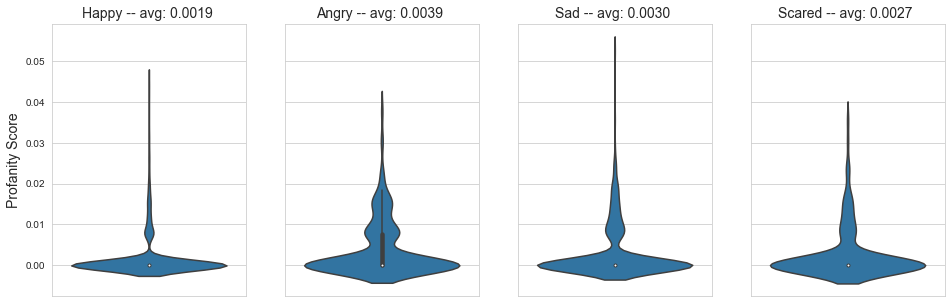

In [436]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(16,5), sharey=True, )
titles = ['Happy', 'Angry', 'Sad', 'Scared']


for i, emoji in enumerate(new_df.groupby('top_emoji').mean().profanity.index):
    sns.violinplot(y=new_df[new_df.top_emoji==emoji].profanity, ax=axes[i])
    val = new_df[new_df.top_emoji == emoji].profanity.mean()
    axes[i].set_title(f"{titles[i]} -- avg: {val:.4f} ", fontsize=14)    
    if i == 0:
        axes[i].set_ylabel("Profanity Score", fontsize=14)
    else:
        axes[i].set_ylabel("")
plt.show()

From what we see above, tweets, for the most part, range in having a profanity score of 0 to around 5 percent (where the percent is number of profane words to number of words overall)

Anger seems to have the largest amount of profanity, indicated by the heightened thickness higher up on the violinplot compared to the other plots. This makes sense, I and I believe most people would assume the the angry tweets probably have more profanity.

Note the thinness and height of the plots. Sad has the highest scores of the 4 emotions, but, the plot is so thin at that level that it is assumed to be outliers, and thus shouldn't tell as important a story as the thicker sections of the plots.

All in all, I am hoping that the use of this feature in my modeling process will help in differentiating anger.

### Explore Subjectivity

In [409]:
new_df.groupby('top_emoji').mean().subjectivity

top_emoji
😊    0.318200
😡    0.342507
😩    0.371526
😱    0.295751
Name: subjectivity, dtype: float64

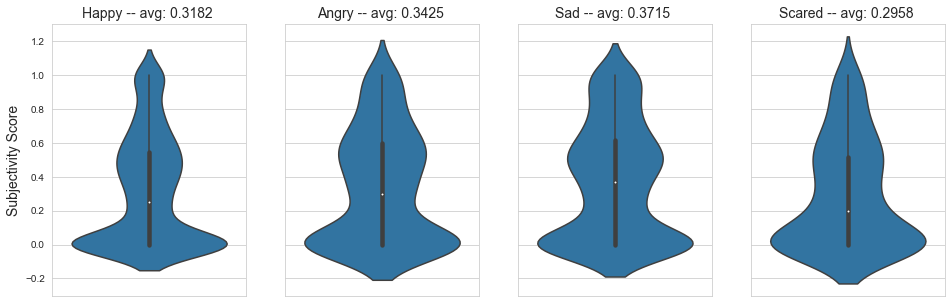

In [435]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(16,5), sharey=True, )
titles = ['Happy', 'Angry', 'Sad', 'Scared']


for i, emoji in enumerate(new_df.groupby('top_emoji').mean().subjectivity.index):
    sns.violinplot(y=new_df[new_df.top_emoji==emoji].subjectivity, ax=axes[i])
    val = new_df[new_df.top_emoji == emoji].subjectivity.mean()
    axes[i].set_title(f"{titles[i]} -- avg: {val:.4f} ", fontsize=14)    
    if i == 0:
        axes[i].set_ylabel("Subjectivity Score", fontsize=14)
    else:
        axes[i].set_ylabel("")
plt.show()

Subjectivity score through the use of textblob gives us an idea of how subjective, or opinionated, a tweet is. My initial reasoning for including this was that people with strong opinions often have strong emotions for those opinions. I wanted to see if any one emotion seems to have the "strongest" level of subjectivity.

From the above results, we can see that fear, overall, is the least subjective, based on the fact that the thickest portion of the violin plot is towards the bottom.

While we do see some differences, I don't think this score will help the model as much as the prior features discussed so far. Nonetheless, I will include it in my training of models and let the algorithms decide their importance.

### Explore Use of Exclamation Points


In [412]:
new_df.groupby('top_emoji').mean().exclamation_points

top_emoji
😊    0.003879
😡    0.005353
😩    0.001567
😱    0.004122
Name: exclamation_points, dtype: float64

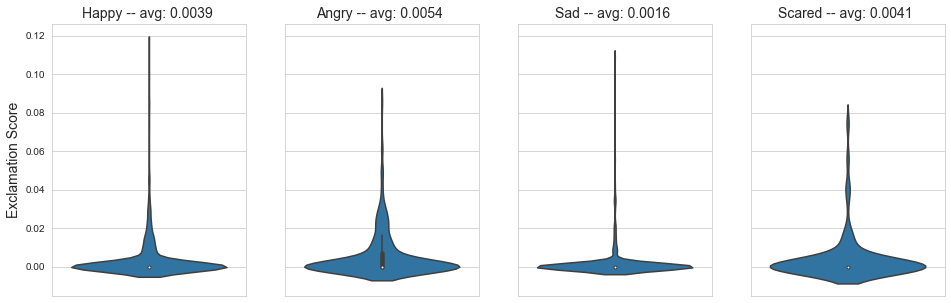

In [433]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(16,5), sharey=True, )
titles = ['Happy', 'Angry', 'Sad', 'Scared']


for i, emoji in enumerate(new_df.groupby('top_emoji').mean().exclamation_points.index):
    sns.violinplot(y=new_df[new_df.top_emoji==emoji].exclamation_points, ax=axes[i])
    val = new_df[new_df.top_emoji == emoji].exclamation_points.mean()
    axes[i].set_title(f"{titles[i]} -- avg: {val:.4f} ", fontsize=14)
    if i == 0:
        axes[i].set_ylabel("Exclamation Score", fontsize=14)
    else:
        axes[i].set_ylabel("")
plt.show()

Next I take a look at a simple metric -- how often do tweets from each emotion group utilize exclamation points?

Values for all groups range (again, on a normalized level of number of !'s present divided by length of tweet) between 0 and 12 percent (at the peak of outliers).

Here, I see what I would have expected. Anger uses the most exclamation points and sadness uses the least. When people are angry, they yell and fight, which exclamation points signify in text. When people are sad, they act withdrawn and melancholy, which means a lack of exclamation points in text.

I believe that including this feature in my models will further help in identifying differences between emotions.

### Explore Capitalization Usage

In [416]:
new_df['capitalization'] = new_df.tweet.progress_apply(capital_percentage)

100%|██████████| 2617/2617 [00:00<00:00, 7362.58it/s]


In [417]:
new_df.groupby('top_emoji').mean().capitalization

top_emoji
😊    0.079763
😡    0.101700
😩    0.076403
😱    0.086708
Name: capitalization, dtype: float64

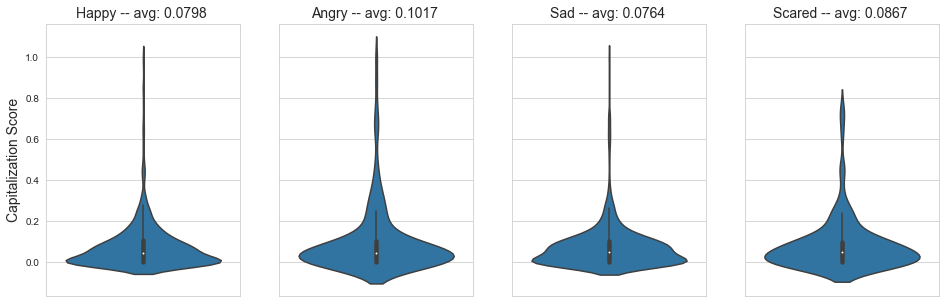

In [432]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(16,5), sharey=True, )
titles = ['Happy', 'Angry', 'Sad', 'Scared']


for i, emoji in enumerate(new_df.groupby('top_emoji').mean().capitalization.index):
    sns.violinplot(y=new_df[new_df.top_emoji==emoji].capitalization, ax=axes[i])
    val = new_df[new_df.top_emoji == emoji].capitalization.mean()
    axes[i].set_title(f"{titles[i]} -- avg: {val:.4f} ", fontsize=14)
    if i == 0:
        axes[i].set_ylabel("Capitalization Score", fontsize=14)
    else:
        axes[i].set_ylabel("")
plt.show()

This next custom feature tells a very similar story to the use of exclamation points. Capitalization, which again is simply count of all caps words divided by length of tweet, gives us a normalized view on the different use between emotion classes.

Here, we again see what we might expect. Anger has the highest usage of capitalization in tweets, which will further help identify anger. At this point, prior to modeling, I am feeling somewhat confident in classifying anger!

Overall though, from a distribution standpoint, I am not sure if there truly is a huge difference between the four classes. Hopefully this adds value to my models.